In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer
import math
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from collections import Counter
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from matplotlib.ticker import MultipleLocator
from sklearn.impute import KNNImputer

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller

pd.set_option('display.max_columns', None)

### Načítanie .txt súboru

In [36]:
dff = pd.read_table("../quest_data/power_consumption.txt",sep=';', dtype=str, low_memory=False)

#
# **4.1 EDA and data preprocessing**

#### **`Active power`** - skutočná energia, ktorá sa v sieti využíva.
#### **`Reactive power`** - nepoužitá energia, ktorá iba prúdi v sieti.
#### **`Apparent power`** - celková energia, ktorá je v sieti prítomná.
#### **`Sub_metering_1`** - energia spotrebovaná v kuchyni: umývačku riadu, rúra a mikrovlnná rúra.
#### **`Sub_metering_2`** - energia spotrebovaná v práčovni: práčka, sušička, chladnička a svetlo.
#### **`Sub_metering_3`** - energia spotrebovaná: elektrický ohrievač vody a klimatizácia.

#
## *A) EDA a data preprocessing pre Vami vybrané charakteristiky z datasetu*

### Názvy atribútov

In [37]:
dff.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

### Počet záznamov

In [38]:
dff.shape

(2075259, 9)

### Prvý pohľad na dáta

In [39]:
dff.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.000


### Zíkladné info o datasete

In [40]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Date                   object
 1   Time                   object
 2   Global_active_power    object
 3   Global_reactive_power  object
 4   Voltage                object
 5   Global_intensity       object
 6   Sub_metering_1         object
 7   Sub_metering_2         object
 8   Sub_metering_3         object
dtypes: object(9)
memory usage: 142.5+ MB


In [41]:
dff.describe(include='all')

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2049280
unique,1442,1440,4187,533,2838,222,89,82,32
top,25/11/2010,20:24:00,?,0.000,?,1.000,0.000,0.000,0.000
freq,1440,1442,25979,481561,25979,172785,1880175,1436830,852092


### Po bližšom preskúmaní sme zistili, že niektoré záznamy ako hodnotu majú: `?`. Pre každý atribút zistíme, koľko `?` obsahuje.

In [42]:
for col in dff.columns:
    count = dff[col].str.contains(r'\?', na=False).sum()
    print(f"{col:<22}: {count}")

print(f"\n{'Columns 3-8':<22}: {dff[dff.columns[2:-1]].apply(lambda col: col.str.contains(r'\?', na=False)).all(axis=1).sum()}")

Date                  : 0
Time                  : 0
Global_active_power   : 25979
Global_reactive_power : 25979
Voltage               : 25979
Global_intensity      : 25979
Sub_metering_1        : 25979
Sub_metering_2        : 25979
Sub_metering_3        : 0

Columns 3-8           : 25979


#### Atribúty 3 až 8 obsahujú rovnaký počet `?`. Overili sme, že ak záznam obsahuje v ktoromkoľvek atribúte hodnotu: `?`, tak potom všetky dalšie atribúty (3 až 8) takisto obsahujú `?` v danom zázname.

### Keďže záznamy iba s `?` nemajú žiadnu hodnotu, tak ich vymažeme.

In [43]:
df = dff[~dff.apply(lambda col: col.map(lambda x: '?' in str(x))).any(axis=1)].copy()

### Overíme duplicitné záznamy.

In [44]:
df.duplicated().sum()

np.int64(0)

### Overíme chýbajúce hodnoty.

In [45]:
df.isna().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### Atribúty `Date` a `Time` spojíme do nového atribútu `DateTime` a pretypujeme na `datetime64`.

In [46]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

### `DateTime` presunieme na začiatok; `Date` a `Time` môžeme vymazať.

In [47]:
df.insert(0, 'DateTime', df.pop('DateTime'))
df.drop(columns=['Date', 'Time'], inplace=True)

### Keďže pracujeme s číselnými hodnotami, tak pretypujeme atribúty na zodpovedajúce typy: `float` a `int`.

In [48]:
for column in df.columns[1:-3]:
    df[column] = pd.to_numeric(df[column], errors="coerce").astype(float)

for column in df.columns[-3:]:
    df[column] = pd.to_numeric(df[column], errors="coerce").astype(int)

### Zobrazíme korelácie atribútov na `Heat-Map`. 

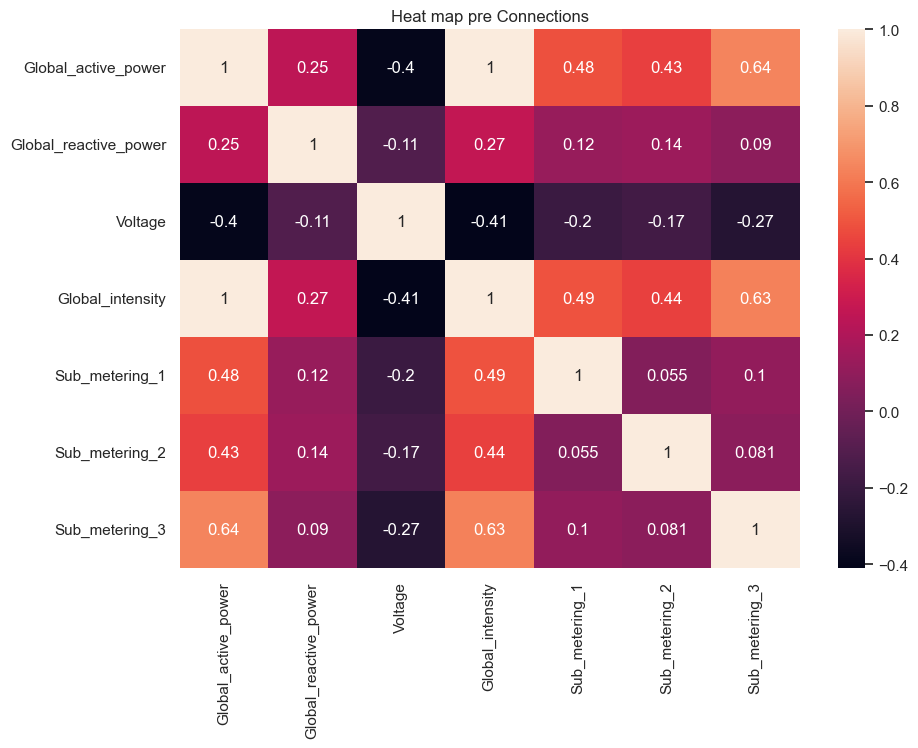

In [49]:
df_corr=df.iloc[:, 1:].corr()

fig, ax = plt.subplots(figsize=(10,7))

ax.set_title('Heat map pre Connections', fontsize=12)

sns.heatmap(df_corr, annot=True)
plt.show()

### Zoradíme záznamy podľa času merania (už teraz vyzerajú byť zoradené), aby sme mali istotu.

In [50]:
df.sort_values(by='DateTime', inplace=True)

### Počet meraní pre jednotlivé roky z datasetu.

In [51]:
for year, count in df.groupby(df['DateTime'].dt.year).size().items():
    print(f'{year} : {count:,}')

2006 : 21,992
2007 : 521,669
2008 : 526,905
2009 : 521,320
2010 : 457,394


#
#### `Funkcia:` Zobrazenie info o záznamoch a dátumoch.

In [52]:
def show_stats(dataframe):
    min_dates_per_year = dataframe.groupby(dataframe['DateTime'].dt.year)['DateTime'].min()
    max_dates_per_year = dataframe.groupby(dataframe['DateTime'].dt.year)['DateTime'].max()

    print(f"{'Rok':<6} {'Od':<12} {'Do':<12} {'v DF':<6} {'Má byť':<8} {'Rozdiel'}")
    print("-" * 60)

    should = [16, 365, 366, 365, 330]

    for (year, count), real_count in zip(dataframe.groupby(dataframe['DateTime'].dt.year).size().items(), should):
        min_date = min_dates_per_year[year]
        max_date = max_dates_per_year[year]
        
        print(f'{year:<6} {min_date.strftime("%Y-%m-%d"):<12} {max_date.strftime("%Y-%m-%d"):<12} {count:<6} {real_count:<8} {real_count - count}')

#### `Funkcia:` Zobrazenie chýbajúcich dátumov.

In [53]:
def show_missing_dates(dataframe):
    copied = dataframe.copy()
    copied = copied.set_index('DateTime')
    
    start_date = copied.index.min()
    end_date = copied.index.max()

    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    existing_dates = copied.index
    missing_dates = all_dates.difference(existing_dates)

    missing_dates_by_year = missing_dates.to_series().groupby(missing_dates.year).apply(list)

    for year, dates in missing_dates_by_year.items():
        print(f"\n{year}\n⁻⁻⁻⁻⁻⁻⁻")
        for date in dates:
            print(f"  {date.date()}")

#
### Vieme už, že nemáme záznamy pre kompletne celé roky. Chceme však zistiť, či máme merania pre každý deň od `12/2006` až `11/2010`.

In [54]:
df_including = df.resample('D', on='DateTime').mean().reset_index()
show_stats(dataframe=df_including)

Rok    Od           Do           v DF   Má byť   Rozdiel
------------------------------------------------------------
2006   2006-12-16   2006-12-31   16     16       0
2007   2007-01-01   2007-12-31   365    365      0
2008   2008-01-01   2008-12-31   366    366      0
2009   2009-01-01   2009-12-31   365    365      0
2010   2010-01-01   2010-11-26   330    330      0


In [55]:
show_missing_dates(dataframe=df_including)

In [56]:
df_including.isna().sum()

DateTime                 0
Global_active_power      9
Global_reactive_power    9
Voltage                  9
Global_intensity         9
Sub_metering_1           9
Sub_metering_2           9
Sub_metering_3           9
dtype: int64

#### Napriek tomu, že sa počty dni zhodujú a žiadne chýbajúce dni sa nevypísali, ak overíme `Na` hodnoty, tak ich máme 9 v každom atribúte.
### Vypíšeme záznamy s `Na` hodnotami.

In [57]:
df_including[df_including.isna().any(axis=1)]

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
134,2007-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
911,2009-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1124,2010-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341,2010-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1342,2010-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1343,2010-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1344,2010-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1380,2010-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1381,2010-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Vidíme, že záznamov je 9 a všetky atribúty okrem `DateTime` sú `Na`. Znamená to, že pre týchto 9 dní nemáme žiadne zaznamenané merania.
#
### Ak pre porovnanie budeme brať do úvahy iba dni, ktoré majú aspoň jedno zaznamenané meranie tak:

In [58]:
df_excluding = df.groupby(df['DateTime'].dt.date, as_index=False).mean()
df_excluding['DateTime'] = pd.to_datetime(df_excluding['DateTime']).dt.normalize()
show_stats(dataframe=df_excluding)

Rok    Od           Do           v DF   Má byť   Rozdiel
------------------------------------------------------------
2006   2006-12-16   2006-12-31   16     16       0
2007   2007-01-01   2007-12-31   364    365      1
2008   2008-01-01   2008-12-31   366    366      0
2009   2009-01-01   2009-12-31   364    365      1
2010   2010-01-01   2010-11-26   323    330      7


In [59]:
show_missing_dates(dataframe=df_excluding)


2007
⁻⁻⁻⁻⁻⁻⁻
  2007-04-29

2009
⁻⁻⁻⁻⁻⁻⁻
  2009-06-14

2010
⁻⁻⁻⁻⁻⁻⁻
  2010-01-13
  2010-08-18
  2010-08-19
  2010-08-20
  2010-08-21
  2010-09-26
  2010-09-27


In [60]:
df_excluding.isna().sum()

DateTime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

#### Vidíme, že získame tých istých 9 dní ako predtým.

#
### Vypočítanie `Apparent_power` pre vypočítanie `Efficiency`.

In [61]:
# df['Apparent_power'] = np.sqrt(df['Global_active_power']**2 + df['Global_reactive_power']**2).round(3)
# df['Efficiency'] = (df['Global_active_power'] / df['Apparent_power'] * 100).round(2)

# df.insert(3, 'Apparent_power', df.pop('Apparent_power'))
# df.insert(4, 'Efficiency', df.pop('Efficiency'))

### Porovnanie celkových hodnôt atribútov podľa rokov.

In [62]:
df.resample('YE', on='DateTime').sum().astype(int)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-31,41813,2889,5309773,176594,27460,48712,162951
2007-12-31,582708,61225,124879155,2485492,642548,854360,3022840
2008-12-31,564893,61705,126787268,2398458,584784,661905,3179187
2009-12-31,562315,68505,126104354,2374625,592657,592145,3556816
2010-12-31,485295,59199,110467752,2048404,451686,503909,3313373


#
#### `Funkcia:` Zobrazenie priemernej `Global_active_power` za dané obdobie.

In [63]:
def show_power_graph(df, by):
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(15, 7))
    sns.lineplot(data=df, x='DateTime', y='Global_active_power', color='#10375C')

    plt.title(f'Priemerná {by}spotreba energie počas obdobia 12/2006 - 10/2010', fontsize=16)
    plt.xlabel('Obdobie', fontsize=12)
    plt.ylabel('Priemerná spotreba energie', fontsize=12)
    plt.xticks()
    plt.tight_layout()
    plt.show()

### Priemerná spotreba `Global_active_power` každú minútu.

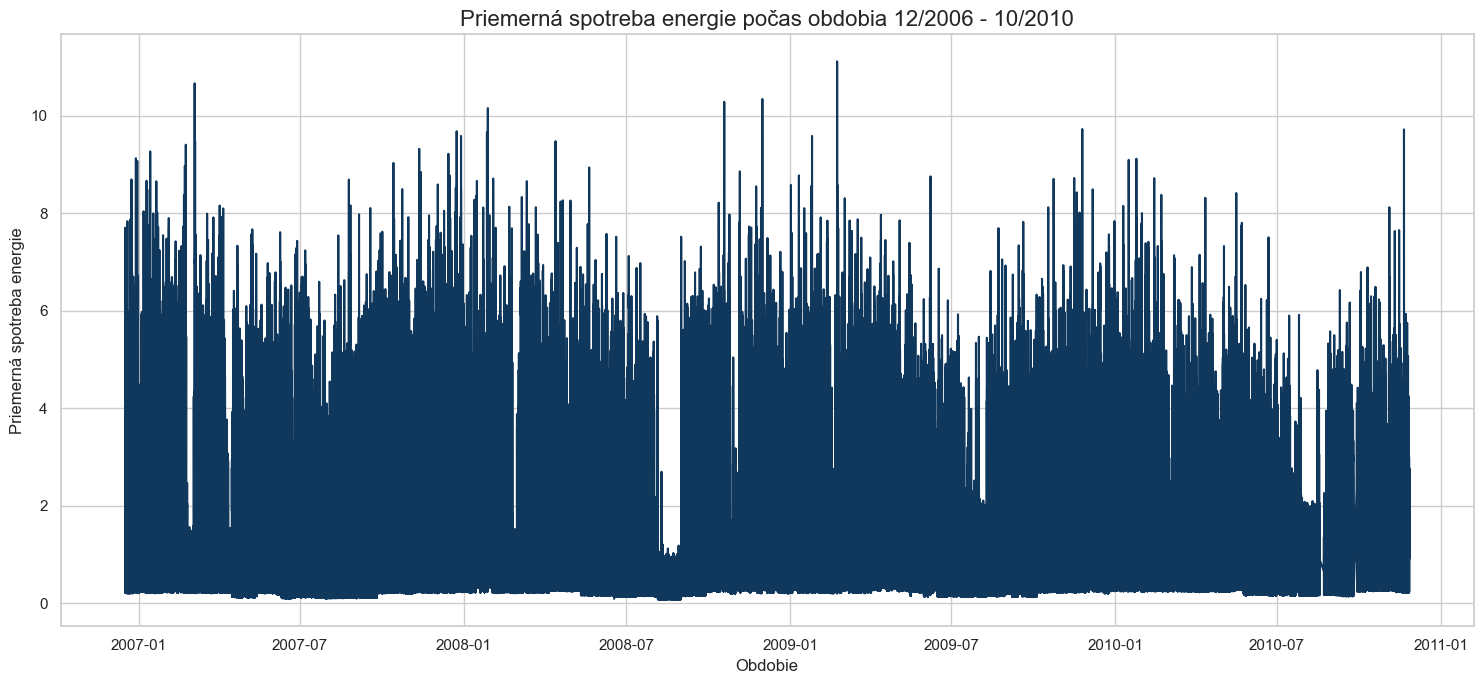

In [64]:
show_power_graph(df=df, by="")

### Priemerná spotreba `Global_active_power` každý deň.

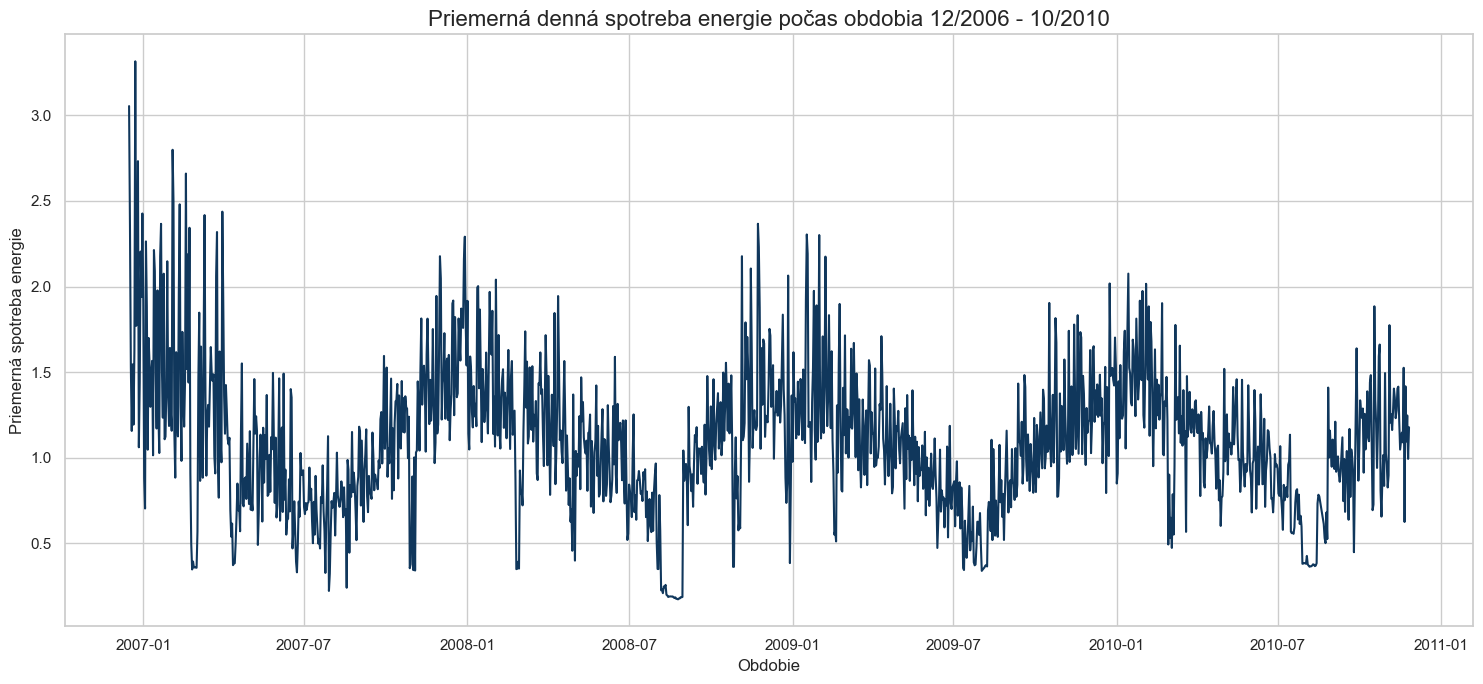

In [65]:
df_day = df.resample('D', on='DateTime').mean().reset_index()
show_power_graph(df=df_day, by="denná ")

### Porovnanie priemerných `Global_active_power` pre jednotlivé roky.

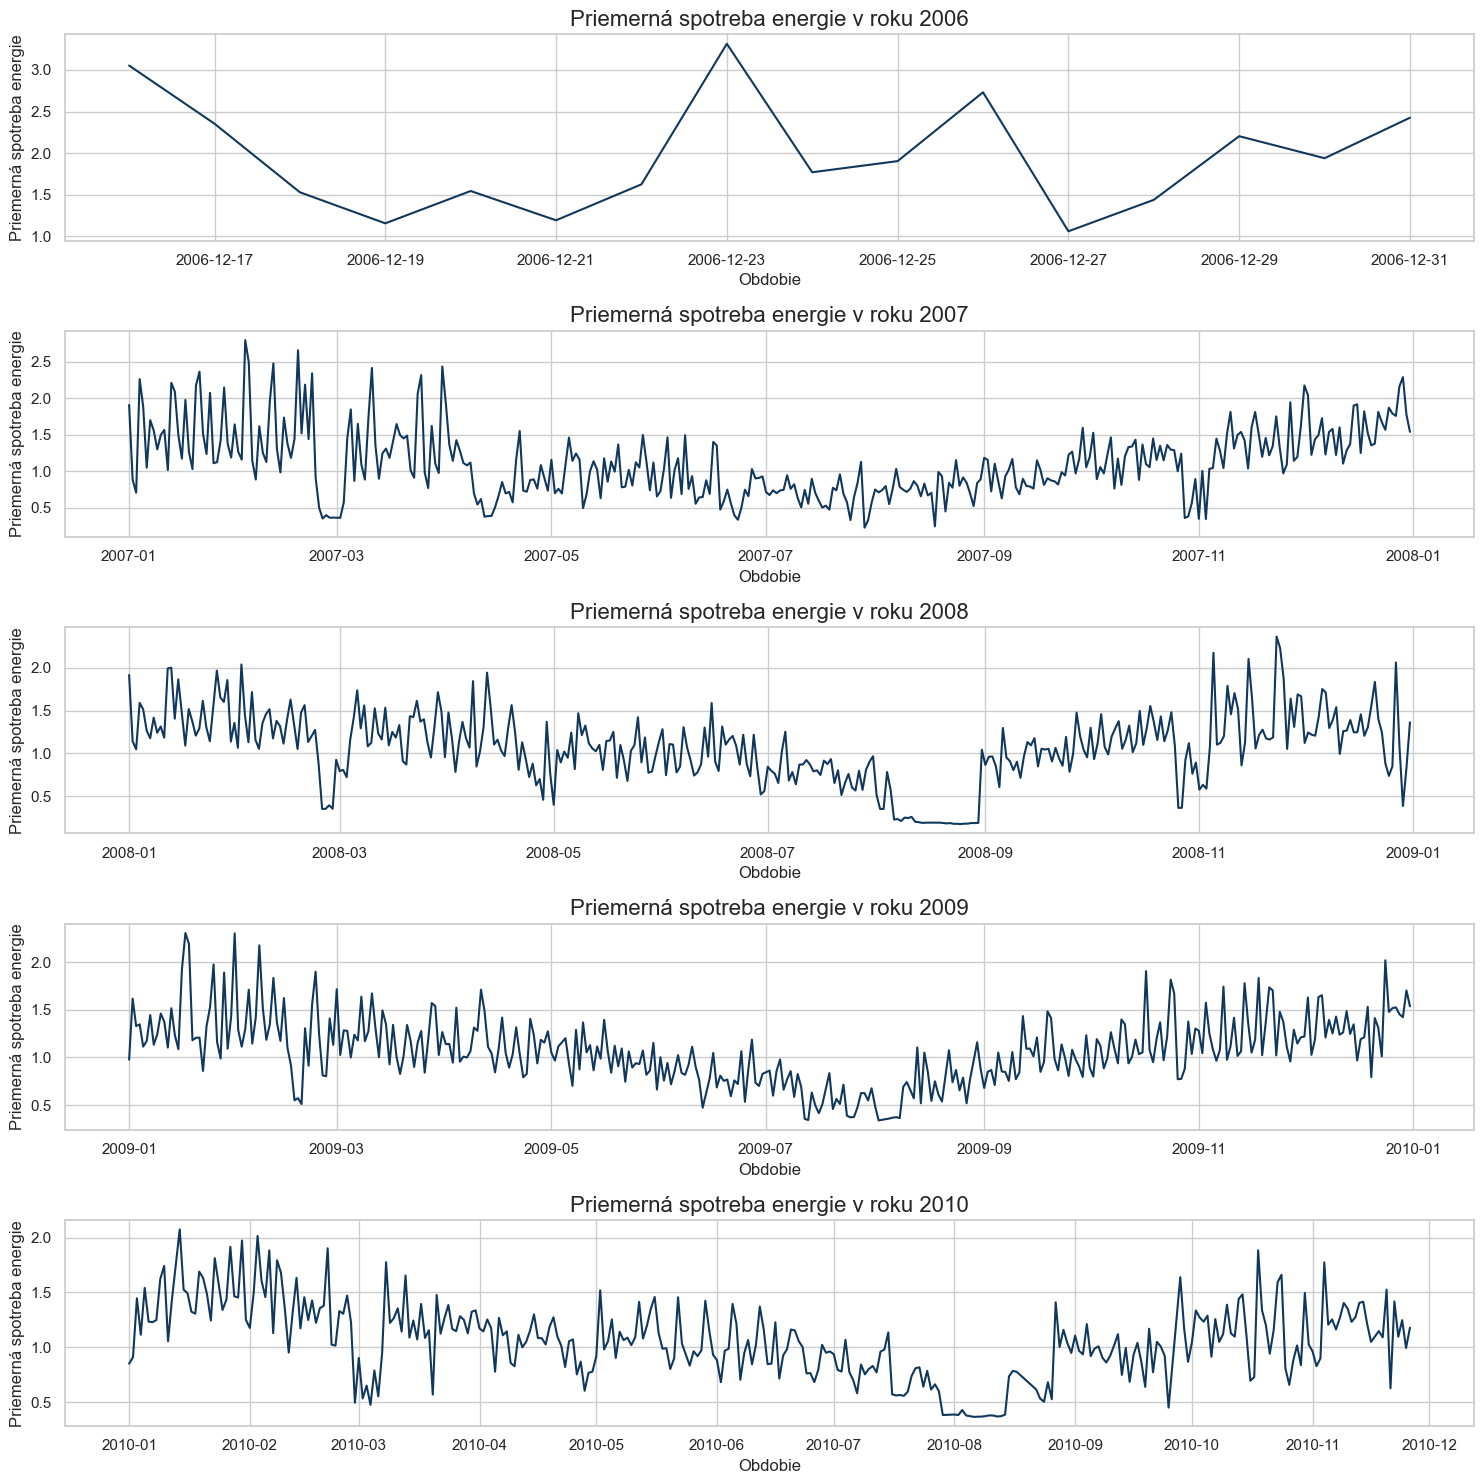

In [67]:
def show_power_graph(df):
    sns.set_theme(style="whitegrid")

    years = [2006, 2007, 2008, 2009, 2010]

    fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(15, 3 * len(years)))
    
    if len(years) == 1:
        axes = [axes]
    
    for i, year in enumerate(years):
        df_year = df[df['DateTime'].dt.year == year]

        sns.lineplot(data=df_year, x='DateTime', y='Global_active_power', color='#10375C', ax=axes[i])
        
        axes[i].set_title(f'Priemerná spotreba energie v roku {year}', fontsize=16)
        axes[i].set_xlabel('Obdobie', fontsize=12)
        axes[i].set_ylabel('Priemerná spotreba energie', fontsize=12)

    plt.tight_layout()
    plt.show()

show_power_graph(df_day)

#### `Funkcia:` Porovanie 2 atribútov za jednotlivé roky na `bar-plote`.

In [68]:
def attributes_comparison(attr1, type1, attr2, type2):
    df_comparison = df.resample('YE', on='DateTime')[[attr1, attr2]].sum()

    active_color = '#10375C'
    reactive_color = '#EB8317'
    width = 0.35
    x = df_comparison.index.year

    plt.figure(figsize=(14, 7))

    plt.bar(x - width / 2, df_comparison[attr1], width=width, color=active_color, label=f'{attr1} ({type1})')
    plt.bar(x + width / 2, df_comparison[attr2], width=width, color=reactive_color, label=f'{attr2} ({type2})')

    for i, (active, reactive) in enumerate(zip(df_comparison[attr1], df_comparison[attr2])):
        plt.text(x[i] - width / 2, active + 0.1, f'{active:,.0f}', ha='center', va='bottom', fontsize=10, color=active_color)
        plt.text(x[i] + width / 2, reactive + 0.1, f'{reactive:,.0f}', ha='center', va='bottom', fontsize=10, color=reactive_color)

    plt.title(f'Porovnanie súčtov ({attr1} a {attr2}) podľa rokov', fontsize=16)
    plt.xlabel('Rok', fontsize=12)
    plt.ylabel('Rozsah', fontsize=12)
    plt.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()

#
### Porovnanie `Global_active_power` a `Global_reactive_power` pre jednotlivé roky.

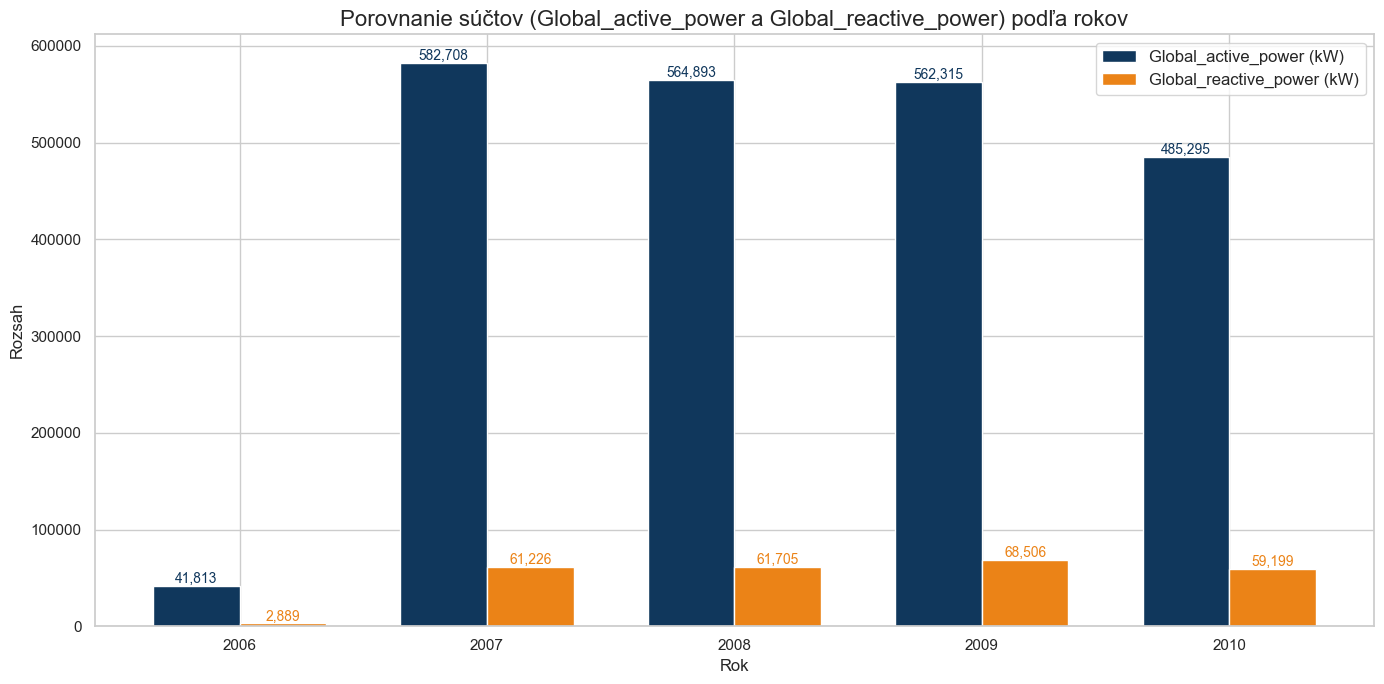

In [69]:
attributes_comparison(attr1='Global_active_power', type1='kW', attr2='Global_reactive_power', type2='kW')

#
### Porovnanie `Sub_metering_1` a `Sub_metering_2` pre jednotlivé roky.

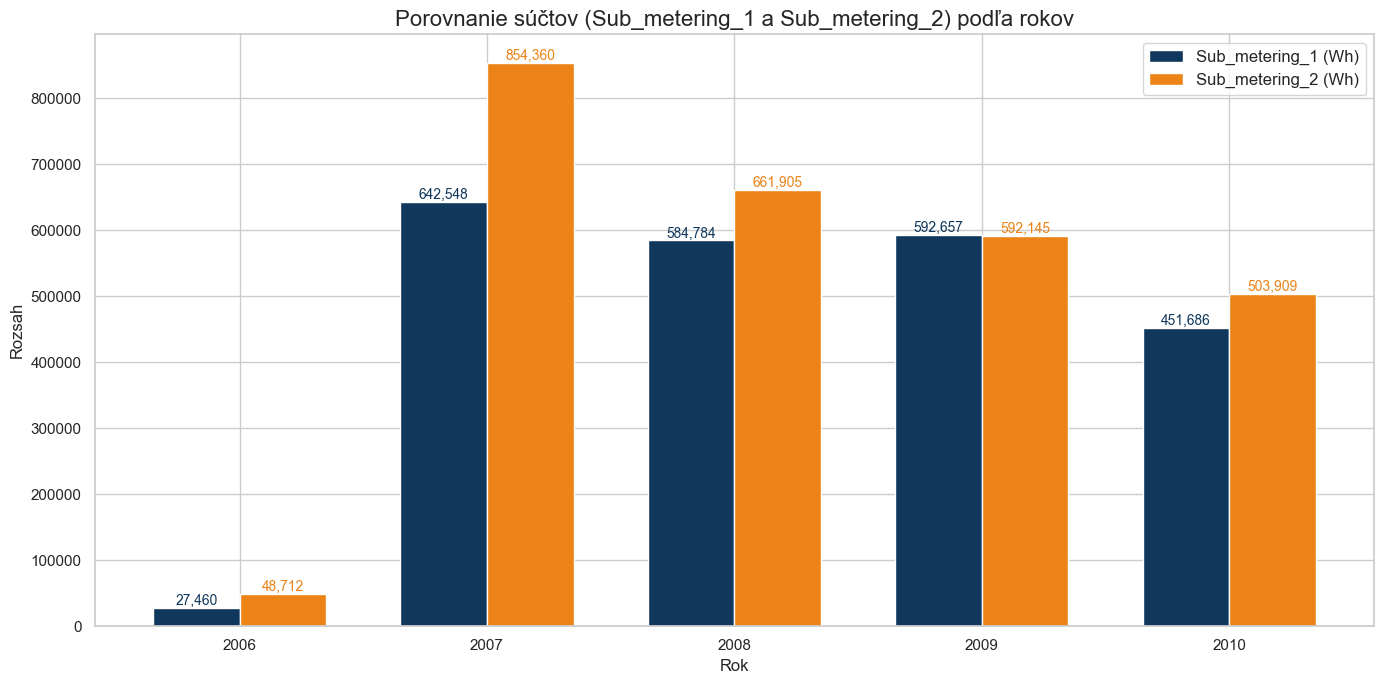

In [70]:
attributes_comparison(attr1='Sub_metering_1', type1='Wh', attr2='Sub_metering_2', type2='Wh')

### Zobrazenie efektivity energie za jednotlivé roky.

In [71]:
# df_efficiency = df.resample('YE', on='DateTime')[['Efficiency']].mean().reset_index()

# plt.figure(figsize=(10, 5))
# plt.plot(df_efficiency['DateTime'], df_efficiency['Efficiency'], marker='o', linestyle='-', color='#10375C')
# plt.title('Priemerná efektivita energie za jednotlivé roky', fontsize=16)
# plt.xlabel('Rok', fontsize=14)
# plt.ylabel('Priemerná efektivita', fontsize=14)
# plt.xticks(df_efficiency['DateTime'], df_efficiency['DateTime'].dt.year, rotation=45)
# plt.ylim(96, None)
# plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

### Doplníme hodnoty pre 9 chýbajúcich dní cez `interpoláciu`.

In [72]:
df_day_all = df_day.interpolate(method='linear')

### Overenie hodnôt chýbajúcích dní.

In [73]:
# missing_indexes = [134, 911, 1124, 1341, 1342, 1343, 1344, 1380, 1381]
# df_day_all.loc[missing_indexes]

### Záznamy bez roku 2006.

In [74]:
df_without_2006 = df_day_all[df_day_all['DateTime'].dt.year != 2006]
df_without_2006.shape

(1426, 8)

### Vybratie atribútu na predikovanie.

In [75]:
gap = df_day_all['Global_active_power']
x_axis = df_day_all['DateTime']

### Rozdelenie dát na `train` a `test`.

In [76]:
train = gap.iloc[:int(len(gap) * 0.8)]
test = gap.iloc[int(len(gap) * 0.8):]

### Overenie stacionarity cez `Augmented Dickey-Fuller test`.

In [77]:
result = adfuller(gap)
print('ADF Test Statistic:', result[0])
print('p-hodnota:', result[1])
print('Kritické hodnoty:', result[4])

if result[1] <= 0.05:
    print("Dáta sú stacionárne")
else:
    print("Dáta nie sú stacionárne")

ADF Test Statistic: -3.6656968507088403
p-hodnota: 0.004622363666274528
Kritické hodnoty: {'1%': np.float64(-3.434966750462565), '5%': np.float64(-2.8635789736973725), '10%': np.float64(-2.5678555388041384)}
Dáta sú stacionárne


###### Interpretácia:
###### ADF Test Statistic (-3.684): Nižšia hodnota ako všetky kritické hodnoty (-3.43 pre 1 %, -2.86 pre 5 %, atď.) naznačuje, že nulovú hypotézu (nestacionarita) zamietame. p-hodnota (0.004): Je pod 0.05, čo znamená, že je štatisticky významné zamietnuť nulovú hypotézu.
###### Čo to znamená? Dáta neobsahujú jednotkový koreň, teda priemerná hodnota a variancia sú približne konštantné v čase. Môžeš priamo použiť model ARIMA bez potreby diferenciácie.

### Zobrazenie `ACF` a `PACF` grafov.

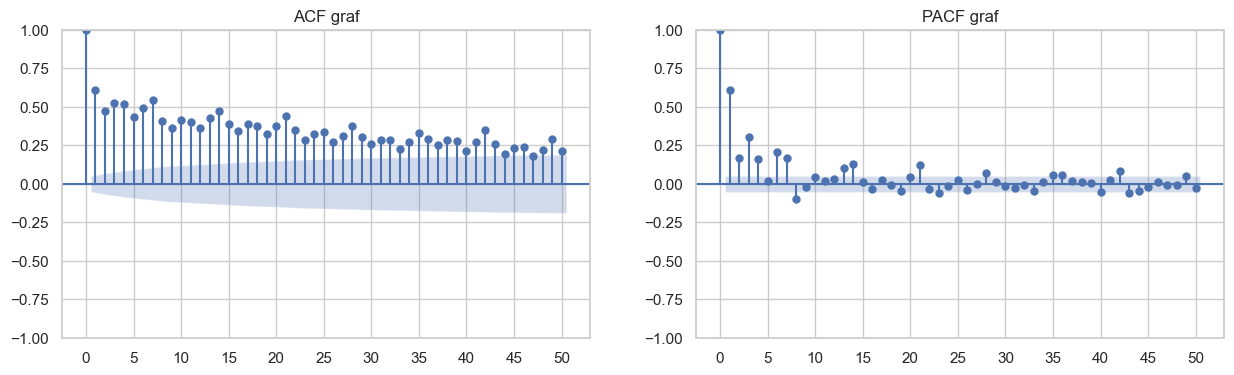

In [78]:
plt.figure(figsize=(15, 4))

# ACF
plt.subplot(121)
plot_acf(gap, lags=50, ax=plt.gca())
plt.xticks(ticks=range(0, 51, 5))
plt.title('ACF graf')

# PACF
plt.subplot(122)
plot_pacf(gap, lags=50, ax=plt.gca(), method='ywm')
plt.xticks(ticks=range(0, 51, 5))
plt.title('PACF graf')

plt.show()

#### `Funkcia:` Vykreslenie výsledkov predikcie.

In [79]:
def plot_forecasts(train, test, forecasts, x_axis, title):
    fig = go.Figure()

    # TRAIN
    fig.add_trace(go.Scatter(x=x_axis[:len(train)], y=train, 
                             mode='lines', name='Train', line=dict(color='blue')))
    
    # TEST
    fig.add_trace(go.Scatter(x=x_axis[len(train):], y=test, 
                             mode='lines', name='Test', line=dict(color='orange')))
    
    # FORECAST
    fig.add_trace(go.Scatter(x=x_axis[len(train):], y=forecasts, 
                             mode='lines', name='Forecast', line=dict(color='green')))
    
    fig.update_layout(
        template="simple_white",
        font=dict(size=16),
        title_text=title,
        title_x=0.5,
        xaxis_title='DateTime',
        yaxis_title='Global Active Power',
        width=1150,
        height=500
    )
    
    fig.show()

### Volanie `ARIMA` modelu a zobrazenie predikcie.

In [80]:
X_selected = df_day_all[['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]

model = ARIMA(endog=train, exog=X_selected[:len(train)], order=(10,0,7), seasonal_order=(1,1,1,12)).fit() #  
forecast = model.forecast(steps=len(test), exog=X_selected[len(train):]) # 

plot_forecasts(train, test, forecast, x_axis, "ARIMA Predikcia")

c:\Users\robko\Desktop\skola\STU FIIT\5. semester\IAU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#
## *B) Zdôvodnite výber ML/DL metód vzhľadom na Vami vybraný dataset pre 4.2*

#
# **4.2 Modeling and evaluation**

#
## *A) Modeluje Vami tie vybrané charakteristiky pomocou vhodných ML/DL metód. Výsledok modelovania je najlepší model*

In [ ]:
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

from keras.callbacks import EarlyStopping

In [ ]:
def plot_forecasts2(train, test, forecasts, x_axis, title):
    fig = go.Figure()

    # TRAIN
    fig.add_trace(go.Scatter(x=x_axis[:len(train)], y=train, 
                             mode='lines', name='Train', line=dict(color='blue')))
    
    # TEST
    fig.add_trace(go.Scatter(x=x_axis[len(train):], y=test, 
                             mode='lines', name='Test', line=dict(color='orange')))
    
    # FORECAST
    fig.add_trace(go.Scatter(x=x_axis[len(train):], y=forecasts, 
                             mode='lines', name='Forecast', line=dict(color='green')))
    
    fig.update_layout(
        template="simple_white",
        font=dict(size=16),
        title_text=title,
        title_x=0.5,
        xaxis_title='DateTime',
        yaxis_title='Global Active Power',
        width=1150,
        height=500
    )
    
    fig.show()

In [150]:
data = df_day_all["Global_active_power"].values.reshape(-1,1)
data

array([[3.05347475],
       [2.35448611],
       [1.53043472],
       ...,
       [1.24739444],
       [0.99386389],
       [1.17822961]])

In [151]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [152]:
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

In [ ]:
look_back = 30
X, y = create_sequences(scaled_data, look_back)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Input(shape = (X_train.shape[1], 1)),
    LSTM(50),
    # Dense(25),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

In [190]:
history = model.fit(X_train, y_train, epochs=20, batch_size=1240, validation_data=(X_test, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=4)], verbose=1, shuffle=False)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0905 - val_loss: 0.0778
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0753 - val_loss: 0.0641
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0619 - val_loss: 0.0518
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0497 - val_loss: 0.0409
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0384 - val_loss: 0.0315
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0310 - val_loss: 0.0237
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0229 - val_loss: 0.0175
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0169 - val_loss: 0.0133
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0131 - val_loss: 0.0113
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0119 - val_loss: 0.0137
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0145 - val_loss:

In [191]:
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [192]:
train_actual = scaler.inverse_transform(y[:len(X_train)])
test_actual = scaler.inverse_transform(y[len(X_train):])

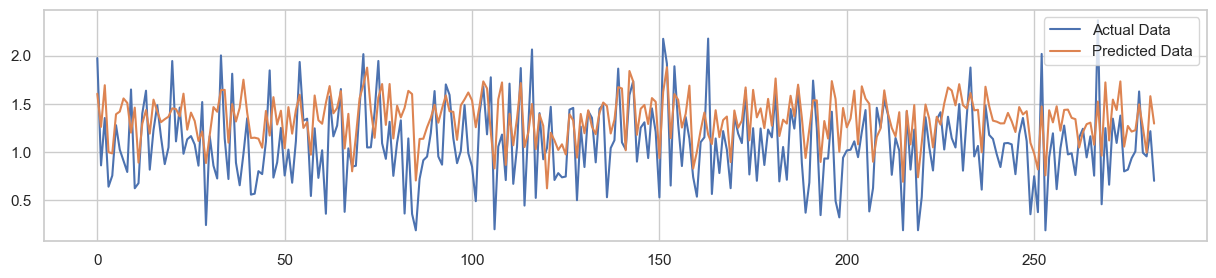

In [193]:
plt.figure(figsize=(15, 3))
plt.plot(y_test_actual, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.legend()
plt.show()

In [ ]:
model2 = Sequential([
    Input(shape = (X_train.shape[1], 1)),
    LSTM(100),
    # Dense(25),
    Dropout(0.25),
    Dense(1)
])
model2.compile(optimizer='adam', loss='mean_squared_error')

In [326]:
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=1240, validation_data=(X_test, y_test), 
                    verbose=1, shuffle=False)

Epoch 1/20


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1231 - val_loss: 0.0992
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0965 - val_loss: 0.0752
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0725 - val_loss: 0.0545
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0525 - val_loss: 0.0371
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0354 - val_loss: 0.0233
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0227 - val_loss: 0.0141
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0134 - val_loss: 0.0113
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0112 - val_loss: 0.0155
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0163 - val_loss: 0.0208
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0211 - val_loss: 0.0212
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0227 - val_loss: 0.0183
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0189 - val_loss: 0.0149
Epo

In [327]:
predicted2 = model2.predict(X_test)
predicted2 = scaler.inverse_transform(predicted2)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [328]:
plot_forecasts2(
    train=train_actual.flatten(),
    test=y_test_actual.flatten(),
    forecasts=predicted.flatten(),
    x_axis=x_axis,
    title="Global Active Power: Train, Test, and Forecast"
)

In [329]:
plot_forecasts2(
    train=train_actual.flatten(),
    test=y_test_actual.flatten(),
    forecasts=predicted2.flatten(),
    x_axis=x_axis,
    title="Global Active Power: Train, Test, and Forecast"
)

In [330]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [331]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [332]:
print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

Train Mean Absolute Error: 0.07173251690679464
Train Root Mean Squared Error: 0.09661976239126806
Test Mean Absolute Error: 0.07594945461045932
Test Root Mean Squared Error: 0.10394794641936443


In [333]:
train_predict2 = model2.predict(X_train)
test_predict2 = model2.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [335]:
print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict2))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict2)))
print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict2))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict2)))

Train Mean Absolute Error: 0.08138390126149901
Train Root Mean Squared Error: 0.11025827661635657
Test Mean Absolute Error: 0.08576401833894925
Test Root Mean Squared Error: 0.11726599308748534


#
## *B) Zhodnotíte Váš prístup a získaný výsledok*